In [ ]:
# $60,000 - salary cap
# 0.5 PPR, decimal scoring

# QB
# 2 x RB
# 3 x WR
# FLEX
# TE
# DEF

In [ ]:
# Offense: 
# Rushing yards made = 0.1pts  
# Rushing touchdowns = 6pts  
# Passing yards = 0.04pts  
# Passing touchdowns = 4pts  
# Interceptions = -1pt  
# Receiving yards = 0.1pts  
# Receiving touchdowns = 6pts  
# Receptions = 0.5pts
# Fumbles lost = -2pts  
# Two-point conversions = 2pts

In [ ]:
# model -> project points per player
#-    Stats
#     Usage
#     Percentage of team scoring
#-    Injuries
#-    Bye week
#     Injuries to Key Teammates
#-    Opposing Team (record, defense, injuries, etc.)
#     Home/Away
#     Weather

# maximize value (pts/salary)

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# Year DF

In [16]:
!ls

2020 + Week 1 2021 Analysis.ipynb
2021_fantasy_data
FF21_DataScrape.ipynb
FF21_Experiments.ipynb
FF21_Scoring_Projections.ipynb
Linear Optimization - Stigler Diet.ipynb
Pulp FF optimization.ipynb
historical_fantasy_data
weekly_picks


In [17]:
data_file = "2021_fantasy_data/2021_fantasy_points.txt"

In [3]:
from bs4 import BeautifulSoup
import requests

In [18]:
##Opening new file, scraping rotoguru pages by week, appending to file

f = open(data_file, "w", newline='')
for week in range(1,18):
    url = "http://rotoguru1.com/cgi-bin/fyday.pl?week="+str(week)+"&game=fd&year="+str(2021)+"&scsv=1"
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    data = soup.find_all('pre')[-1]

    f.write(data.text)
    
f.close()

In [5]:
def format_stats(df):
    df = df.dropna()   # remove kickers etc.
    df = df[df['Week'] != 'Week']    # remove 'filler' rows
    df = df.astype({'Week':int, 'Year':int, 'GID':int, 'Name':'string', 
                    'Pos':'string', 'Team':'string', 'h/a':'string', 'Oppt':'string', 
                    'FD points':float, 'FD salary':int})
    # change oak to lvr
    df.loc[df.Oppt=='oak', 'Oppt'] = 'lvr'
    df.loc[df.Team=='oak', 'Team'] = 'lvr'
    return df.rename(columns={'FD points': 'Points', 'FD salary': 'Salary'})

In [19]:
this_year = format_stats(pd.read_csv(data_file, delimiter=';'))
this_year

,Week,Year,GID,Name,Pos,Team,h/a,Oppt,Points,Salary
0,1,2021,1537,"Murray, Kyler",QB,ari,a,ten,34.56,8400
1,1,2021,1523,"Mahomes II, Patrick",QB,kan,h,cle,33.28,8800
2,1,2021,1490,"Goff, Jared",QB,det,h,sfo,29.92,6500
3,1,2021,1465,"Winston, Jameis",QB,nor,h,gnb,29.62,6700
4,1,2021,1131,"Brady, Tom",QB,tam,h,dal,29.16,7800
...,...,...,...,...,...,...,...,...,...,...
6148,14,2021,7024,Pittsburgh,Def,pit,a,min,0.00,3800
6149,14,2021,7022,Las Vegas,Def,lvr,a,kan,-1.00,3100
6150,14,2021,7032,Houston,Def,hou,h,sea,-1.00,3400
6151,14,2021,7020,New York G,Def,nyg,a,lac,-2.00,3800


##  Check Last Week Scores

In [7]:
def last_name_first(df):
    s = df[df['Pos']!='Def']['Name']
    s = s.str.split(' ', expand=True).fillna('')
    s['last_name'] = s.iloc[:, 1:].agg(' '.join, axis=1).str.strip()
    s['join_name'] = s[['last_name',0]].agg(', '.join, axis=1)
    df.loc[df.Pos!='Def', 'Name'] = s.join_name
    return df

In [8]:
week = this_year.Week.max()

this_week = this_year[this_year.Week==week]
df = pd.read_csv(f"weekly_picks/Adam_week{week}_picks.csv")
# df = last_name_first(df)

In [9]:
df = df.join(this_week[['Name', 'Points']].set_index('Name'), on='Name')

print(f"Total Points in Week {week}:", sum(df['Points']))
df

Total Points in Week 14: 161.1


,Pos,Name,Salary,Points
0,RB,"Kamara, Alvin",9000,22.5
1,WR,"Lamb, CeeDee",7800,11.1
2,WR,"Johnson, Diontae",7500,12.8
3,TE,"Kittle, George",7100,27.6
4,QB,"Herbert, Justin",8400,24.9
5,WR,"Jefferson, Justin",8500,17.0
6,RB,"Fournette, Leonard",7600,21.2
7,Def,Kansas City,3700,24.0


#### Other Selections

In [11]:
j = pd.read_csv("/Users/adamschiller/Downloads/jillian_ff_week14.csv", index_col=[0])
j

,Player,Pos,FD SALARY
0,"Tennessee, Titans",DST,4700
1,"Wilson, Russell",QB,7500
2,"Collins, Alex",RB,5600
3,"Hubbard, Chuba",RB,6500
4,"Williams, Javonte",RB,6700
5,"Fant, Noah",TE,5800
6,"Jeudy, Jerry",WR,6300
7,"Lockett, Tyler",WR,7300
8,"Moore, D.J.",WR,6800


In [12]:
def standardize_other_submissions(df):
    df.loc[df.Pos=='D','Pos'] = 'Def'
    df = df.rename({'Player':'Name'}, axis=1)
    df = df.join(this_week[['Name', 'Points']].set_index('Name'), on='Name')
    df = df.fillna(0)
    print(f"Total Points in Week {week}:", sum(df['Points']))
    return df

In [13]:
j = standardize_other_submissions(j)
j

Total Points in Week 14: 103.9


,Name,Pos,FD SALARY,Points
0,"Tennessee, Titans",DST,4700,0.0
1,"Wilson, Russell",QB,7500,21.2
2,"Collins, Alex",RB,5600,2.2
3,"Hubbard, Chuba",RB,6500,9.3
4,"Williams, Javonte",RB,6700,20.8
5,"Fant, Noah",TE,5800,7.1
6,"Jeudy, Jerry",WR,6300,7.2
7,"Lockett, Tyler",WR,7300,24.7
8,"Moore, D.J.",WR,6800,11.4


In [14]:
a = pd.read_csv("/Users/adamschiller/Downloads/Antonio_picks_week_14.csv")
a

,Player,Pos,FD SALARY
0,"Ekeler, Austin",RB,9200
1,"Williams, Javonte",RB,6700
2,"Mixon, Joe",RB,8500
3,"Higgins, Tee",WR,6800
4,"Moore, Elijah",WR,6300
5,"Garoppolo, Jimmy",QB,6700
6,"Seals-Jones, Ricky",TE,4500
7,New York Jets,D,3000
8,"Higgins, Tee",WR,6800


In [15]:
a = standardize_other_submissions(a)
a

Total Points in Week 14: 93.24


,Name,Pos,FD SALARY,Points
0,"Ekeler, Austin",RB,9200,15.40
1,"Williams, Javonte",RB,6700,20.80
2,"Mixon, Joe",RB,8500,7.80
3,"Higgins, Tee",WR,6800,13.90
4,"Moore, Elijah",WR,6300,0.00
5,"Garoppolo, Jimmy",QB,6700,20.14
6,"Seals-Jones, Ricky",TE,4500,1.30
7,New York Jets,Def,3000,0.00
8,"Higgins, Tee",WR,6800,13.90


## Experiments

In [78]:
# calculate averages based on previous week and prior when forecasting this week's points

def add_averages(df):
    df['prev_pts'] = df.groupby('Name')['Points'].shift()
    df['avg points'] = df.groupby('Name')['prev_pts'].transform(lambda x: x.expanding().mean())
    df['rolling3'] = df.groupby('Name')['prev_pts'].transform(lambda x: x.rolling(3,1).mean())
    return df

In [79]:
add_averages(this_year)
this_year

,Week,Year,GID,Name,Pos,Team,h/a,Oppt,Points,FD salary,avg points,rolling3
0,1,2021,1537,"Murray, Kyler",QB,ari,a,ten,34.56,8400,34.560000,34.560000
1,1,2021,1523,"Mahomes II, Patrick",QB,kan,h,cle,33.28,8800,33.280000,33.280000
2,1,2021,1490,"Goff, Jared",QB,det,h,sfo,29.92,6500,29.920000,29.920000
3,1,2021,1465,"Winston, Jameis",QB,nor,h,gnb,29.62,6700,29.620000,29.620000
4,1,2021,1131,"Brady, Tom",QB,tam,h,dal,29.16,7800,29.160000,29.160000
...,...,...,...,...,...,...,...,...,...,...,...,...
3155,7,2021,7023,Philadelphia,Def,phi,a,oak,1.00,3500,4.571429,4.666667
3156,7,2021,7011,Detroit,Def,det,a,lar,0.00,3100,2.857143,3.333333
3157,7,2021,7003,Baltimore,Def,bal,h,cin,-1.00,4300,5.285714,5.333333
3158,7,2021,7006,Chicago,Def,chi,a,tam,-2.00,3700,6.142857,3.333333


In [70]:
this_year[this_year.Name=='Denver']

,Week,Year,GID,Name,Pos,Team,h/a,Oppt,Points,FD salary,prev_pts,avg points,rolling3
443,1,2021,7010,Denver,Def,den,a,nyg,8.0,4100,NaN,NaN,NaN
922,2,2021,7010,Denver,Def,den,a,jac,9.0,4600,8.0,8.00,8.000000
1387,3,2021,7010,Denver,Def,den,h,nyj,19.0,5000,9.0,8.50,8.500000
1874,4,2021,7010,Denver,Def,den,h,bal,3.0,4200,19.0,12.00,12.000000
2351,5,2021,7010,Denver,Def,den,a,pit,3.0,4400,3.0,9.75,10.333333
2769,6,2021,7010,Denver,Def,den,h,oak,1.0,4400,3.0,8.40,8.333333


In [12]:
# opponents = this_year[this_year.Pos!='Def'].groupby(['Week','Oppt']) \
#         .agg({'Points':'sum'}).sort_values('Points')
teams = this_year[this_year.Pos!='Def'].groupby(['Week','Team'], as_index=False) \
        .agg({'Points':'sum', 'Oppt':'first', 'h/a':'first'}) \
        .sort_values(['Week','Points'], ascending=[True,False])

In [13]:
teams

,Week,Team,FD points,Oppt,h/a
10,1,det,120.92,sfo,h
18,1,lvr,117.10,bal,h
8,1,dal,112.42,tam,a
0,1,ari,109.56,ten,a
29,1,tam,108.26,dal,h
...,...,...,...,...,...
182,6,phi,57.10,tam,h
171,6,hou,56.92,ind,a
169,6,det,54.88,cin,h
187,6,was,53.88,kan,h


In [76]:
pvt = pd.pivot_table(this_year, values=['Points'], index=['Week'], columns=['Pos','Name'], fill_value=0)
pvt

FD points                                                        \
Pos        Def                                                         
Name   Arizona Atlanta Baltimore Buffalo Carolina Chicago Cincinnati   
Week                                                                   
1           16       0         4       3        9       0          5   
2            1       1         3      22       12      19          6   
3           21       5         3       7        8       5         12   
4            5       0        11      23       -4       9          1   
5            8       5         6      17        8       9          4   
6           12       0        11       1        9       3          7   

                              ...                                             \
Pos                           ...              WR                              
Name Cleveland Dallas Denver  ... Westbrook, Nick White, Cody Williams, Mike   
Week                          ...                                              
1            1      7      8  ...             1.5         0.0           18.2   
2            5      7      9  ...             1.1         0.0           18.6   
3           16     13     19  ...            11.3         2.7           29.7   
4            8      8      3  ...             4.4         0.0            1.6   
5            0     11      3  ...             0.0         0.0           32.5   
6           -2     13      1  ...             4.2         0.0            3.7   

                                                                        \
Pos                                                                      
Name Williams, Preston Williams, Tyrell Wilson, Albert Wilson, Cedrick   
Week                                                                     
1                  0.0              2.4            0.0            3.90   
2                  0.7              0.0            4.0            3.50   
3                  0.0              0.0            0.0            8.70   
4                  0.0              0.0            1.6           10.00   
5                  8.2              0.0            0.0            5.48   
6                  0.0              0.0            2.4            6.20   

                                                        
Pos                                                     
Name Woods, Robert Zaccheaus, Olamide Zylstra, Brandon  
Week                                                    
1             10.9                0.0              0.0  
2              9.5                3.2             11.9  
3              5.3               10.7              0.0  
4             12.8                2.0              7.3  
5             21.0                3.0              0.0  
6             10.1                0.0              4.7  

[6 rows x 543 columns]

In [77]:
pvt['Points','Def']

Name,Arizona,Atlanta,Baltimore,Buffalo,Carolina,Chicago,Cincinnati,Cleveland,Dallas,Denver,...,New Orleans,New York G,New York J,Philadelphia,Pittsburgh,San Francisco,Seattle,Tampa Bay,Tennessee,Washington
Week,,,,,,,,,,,,,,,,,,,,,
1,16,0,4,3,9,0,5,1,7,8,...,15,4,4,10,14,10,6,2,0,7
2,1,1,3,22,12,19,6,5,7,9,...,6,2,3,1,2,8,4,19,2,3
3,21,5,3,7,8,5,12,16,13,19,...,20,6,4,8,2,0,0,0,3,-4
4,5,0,11,23,-4,9,1,8,8,3,...,2,2,7,-1,5,2,6,9,3,6
5,8,5,6,17,8,9,4,0,11,3,...,6,2,4,12,5,5,3,8,13,5
6,12,0,11,1,9,3,7,-2,13,1,...,0,2,0,1,8,0,3,4,4,8


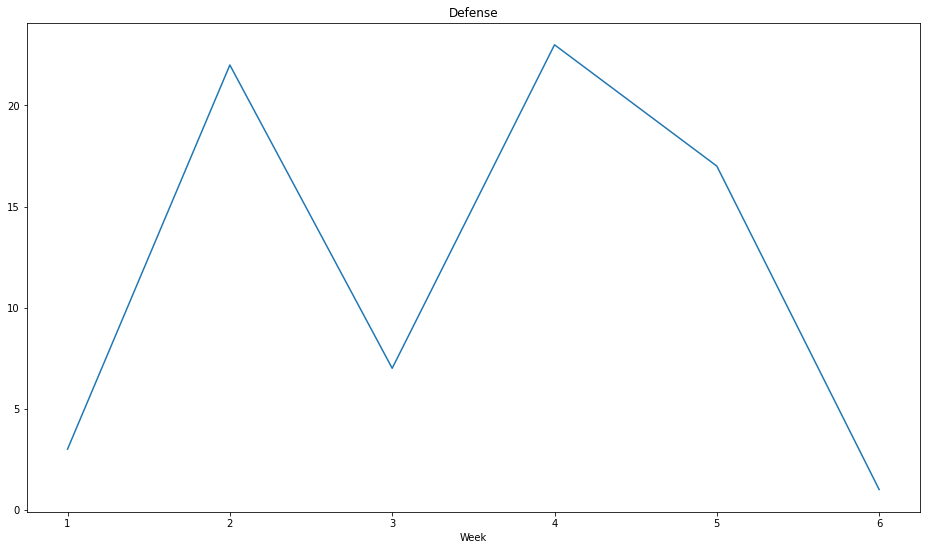

In [83]:
pvt['Points','Def']['Buffalo'].plot(figsize=(16, 9), title='Defense');

# Player DF

In [7]:
def add_averages(df):
    df = df.copy()
    df['total_avg'] = df.groupby('Name')['Points'].transform(lambda x: x.expanding().mean())
    df['last3_avg'] = df.groupby('Name')['Points'].transform(lambda x: x.rolling(3, min_periods=2).mean())
    df['ewm5'] = df.groupby('Name')['Points'].transform(lambda x: x.ewm(span=5, adjust=False, min_periods=2).mean())
#     df['pos_rank'] = df.groupby('Pos')['Points'].rank("dense", ascending=False).astype(int)
    return df.fillna(0)


def reformat_names(df):
    s = df[df['Pos']!='Def']['Name']
    s = s.str.split(', ', expand=True)
    df.loc[df.Pos!='Def', 'Name'] = s[1]+' '+s[0]
    return df


def player_df(df):
    df = add_averages(df)
    df = df.groupby('Name', as_index=False)[['Week','Pos','Team','Points','total_avg','last3_avg','ewm5']].last()
    df.sort_values('total_avg', ascending=False, inplace=True)
    return reformat_names(df)

In [8]:
df = player_df(this_year)
df = df[df.Week>7]

## Remove injured players

Download injury report here:

https://www.rotowire.com/football/injury-report.php

In [9]:
inj = pd.read_csv('2021_fantasy_data/nfl-injury-report.csv')

In [10]:
def format_injuries(inj):
    inj = inj[inj['Pos'].isin(['QB','RB','WR','TE'])]
    inj = inj[inj['Team']!='FA']
    inj.rename(columns={"Player": "Name"}, inplace=True)
    return inj

In [11]:
def remove_injuries(df, inj):
    df = df.join(inj[['Name','Status']].set_index('Name'), on='Name', how='left')
    df = df[df['Status'].isna()]
    return df.drop('Status', axis=1)

In [12]:
df = remove_injuries(df, format_injuries(inj))
df

,Name,Week,Pos,Team,Points,total_avg,last3_avg,ewm5
415,Kyler Murray,13,QB,ari,30.82,23.951111,21.440000,23.097165
64,Tom Brady,13,QB,tam,29.62,23.670000,20.713333,22.135703
242,Justin Herbert,13,QB,lac,26.28,23.481667,27.760000,24.868632
12,Josh Allen,13,QB,buf,11.70,23.403333,19.520000,19.668239
295,Lamar Jackson,13,QB,bal,18.62,22.890909,16.146667,19.443096
...,...,...,...,...,...,...,...,...
600,Davis Webb,10,QB,buf,-0.30,-0.300000,0.000000,0.000000
632,John Wolford,13,QB,lar,0.00,-0.300000,-0.300000,-0.444444
484,Josh Rosen,11,QB,atl,-0.80,-0.310000,-0.413333,-0.364444
45,Travis Benjamin,13,WR,sfo,-2.00,-0.400000,-0.666667,-0.666667


#### Check multi-word names

In [15]:
inj[inj['Player'].str.contains(r' \w+ ')]

,Player,Team,Pos,Injury,Status
255,Shaun Dion Hamilton,DET,LB,Undisclosed,IR


In [16]:
df[df['Name'].str.contains(r' \w+ ')]

,Name,Week,Pos,Team,Points,total_avg,last3_avg,ewm5
365,Patrick Mahomes II,13,QB,kan,13.56,21.196667,19.433333,16.491348
457,Michael Pittman Jr.,13,WR,ind,14.00,11.984615,8.200000,10.931998
40,Odell Beckham Jr.,13,WR,lar,9.80,6.922222,9.733333,8.757598
423,New York G,13,Def,nyg,3.00,6.166667,6.000000,7.008422
511,Laviska Shenault Jr.,13,WR,jac,4.60,6.016667,5.300000,5.114535
424,New York J,13,Def,nyj,1.00,2.750000,3.666667,2.762547
623,Jeff Wilson Jr.,13,RB,sfo,0.00,2.575000,2.500000,2.029630
612,Pooka Williams Jr.,13,RB,cin,0.00,0.000000,0.000000,0.000000
516,Steven Sims Jr.,10,WR,pit,0.00,0.000000,0.000000,0.000000


## Add Salary (remove bye week teams) -- old

In [32]:
# hack to get around certificate issues -- NEED TO FIX
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [33]:
# doesn't include players on bye week
salary = pd.read_html('https://www.fantasypros.com/daily-fantasy/nfl/fanduel-salary-changes.php', header=0)[0]
salary = salary[['Player', 'Opp', 'This Week']]

In [34]:
team_names = {'tb':'tam','sf':'sfo','kc':'kan','ne':'nwe','lv':'lvr','no':'nor','gb':'gnb'}

def format_salary(salary):
    salary = salary.copy()
    # remove $ and cast as int
    salary['Salary'] = salary['This Week'].replace('[\$,]', '', regex=True).astype(int)
    s = salary['Player'].str.split(r' \(', expand=True)
    salary['Name'] = s[0]
    b = s[1].str.split(' - ', expand=True)
    salary['Team'] = b[0].str.lower().replace(team_names)
    salary['Pos'] = np.frompyfunc(lambda x:x[:2],1,1)(b[1])
    salary.loc[salary.Pos=='DS', 'Pos'] = 'Def'
    salary['Opp'] = salary['Opp'].str.replace('@', '').str.lower().replace(team_names)
    return salary[['Name', 'Team', 'Opp', 'Pos', 'Salary']]

In [35]:
def add_salary(df, salary):
    # join defenses only on team names (salary/df names don't line up)
    d = df[df.Pos=='Def']
    s = salary[salary.Pos=='Def'].copy()
    d = d.join(s[['Team','Opp','Salary']].set_index('Team'), on='Team', how='inner')

    # join players on names
    p = df[df.Pos!='Def']
    s = salary[salary.Pos!='Def'].copy()
    p = p.join(s[['Name','Opp','Salary']].set_index('Name'), on='Name', how='inner')

    # merge two together
    return pd.concat([p,d])

In [36]:
salary = format_salary(salary)

In [37]:
df = add_salary(df, salary)
df

,Name,Week,Pos,Team,Points,total_avg,last3_avg,ewm5,Opp,Salary
11,Josh Allen,12,QB,buf,28.70,24.467273,22.933333,23.652358,nwe,8800
292,Lamar Jackson,12,QB,bal,13.40,23.318000,20.820000,19.854644,pit,8500
239,Justin Herbert,12,QB,lac,21.72,23.227273,23.333333,24.162949,cin,8200
63,Tom Brady,12,QB,tam,12.24,23.129091,15.840000,18.393554,atl,8100
555,Jonathan Taylor,12,RB,ind,17.70,22.175000,30.400000,27.850137,hou,10500
...,...,...,...,...,...,...,...,...,...,...
294,Jacksonville,12,Def,jac,3.00,3.636364,2.000000,3.656810,lar,3000
345,LA Chargers,12,Def,lac,3.00,3.545455,2.000000,2.221596,cin,3600
139,Detroit,12,Def,det,4.00,3.454545,7.333333,4.914529,min,3100
24,Atlanta,12,Def,atl,6.00,3.000000,3.333333,4.014259,tam,3200


#### Check non-matching columns

In [19]:
m = df.merge(salary, on='Name', how='outer', suffixes=['', '_'], indicator=True)

In [20]:
x = m[m._merge=='right_only']
x[~x['Points'].isna()]

,Name,Pos,Team,Points,total_avg,last3_avg,ewm5,Opp,Salary,Team_,Opp_,Pos_,Salary_,_merge


## Opposition Effect

- Adjust points based on normalized average points per pos against current opponent

In [38]:
def normalize(p): return (p - p.mean())/p.std()

def opp_pos_norm(season_df, player_df):
    o = season_df.groupby(['Oppt','Pos','Week'], as_index=False).agg({'Points':'sum'})
    o = o.groupby(['Oppt','Pos'], as_index=False).agg({'Points':'mean'})
    o['norm'] = o.groupby('Pos')['Points'].transform(lambda x: normalize(x))
    o = o.rename(columns={'Oppt':'Opp'}).drop(columns='Points')
    return pd.merge(player_df, o, how='left', left_on=['Opp','Pos'], right_on=['Opp','Pos'])
    
def points_adjusted(df, col, mult_factor=2):
    df['Pts Adjusted'] = df[col] + (mult_factor*df['norm'])
    return df

def avg_per_dollar(df, col):
    df['Avg Value'] = df[col] / (df['Salary'] / 1000)
    return df.sort_values('Avg Value', ascending=False)

In [39]:
d = opp_pos_norm(this_year, df)
d = points_adjusted(d, col='ewm5', mult_factor=1.5)
d = avg_per_dollar(d, 'Pts Adjusted')
d

,Name,Week,Pos,Team,Points,total_avg,last3_avg,ewm5,Opp,Salary,norm,Pts Adjusted,Avg Value
375,Miami,12,Def,mia,23.0,7.500000,15.333333,13.590956,nyg,4000,0.261107,13.982616,3.495654
383,Kansas City,11,Def,kan,15.0,5.727273,11.000000,9.483632,den,3300,0.405443,10.091796,3.058120
371,Tampa Bay,12,Def,tam,12.0,8.454545,10.000000,9.722976,atl,4300,2.185582,13.001349,3.023570
27,Leonard Fournette,12,RB,tam,40.6,15.536364,21.400000,21.789392,atl,7700,0.713541,22.859704,2.968793
367,New England,12,Def,nwe,14.0,11.250000,17.666667,16.281540,buf,5000,-1.134137,14.580334,2.916067
...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,Davis Webb,10,QB,buf,-0.3,-0.300000,0.000000,0.000000,nwe,6000,-2.118226,-3.177339,-0.529557
339,Kahale Warring,8,TE,buf,0.0,0.000000,0.000000,0.000000,nwe,4100,-1.536600,-2.304900,-0.562171
347,J.P. Holtz,12,TE,chi,0.0,0.000000,0.000000,0.000000,ari,4000,-1.626342,-2.439514,-0.609878
309,Gunner Olszewski,12,WR,nwe,0.0,0.245455,0.000000,0.177778,buf,4500,-2.594852,-3.714500,-0.825444


#### Old version
- Adjust points based on the opponents' normalized avg (def: offense; players: defense)

In [66]:
# normalized offense pts / team
def offense_adjustment_factor(df):
    offense = df[df.Pos!='Def'].groupby('Team', as_index=False).agg({'Points':'sum'}) \
            .sort_values('Points', ascending=False)
    pts = offense['Points']
    offense['norm'] = (pts-pts.mean())/pts.std()
    return offense[['Team','norm']]

In [67]:
# normalized defense pts / team
def defense_adjustment_factor(df):
    defense = df[df.Pos=='Def'].copy()
    pts = defense['Points']
    defense['norm'] = (pts-pts.mean())/pts.std()
    return defense[['Team','norm']]

In [202]:
def add_opposition_factor(df):
    # join defenses only on team names (salary/df names don't line up)
    d = df[df.Pos=='Def']
    offense = offense_adjustment_factor(df).copy()
    d = d.join(offense.set_index('Team'), on='Opp', how='left')

    # join players on names
    p = df[df.Pos!='Def']
    defense = defense_adjustment_factor(df).copy()
    p = p.join(defense.set_index('Team'), on='Opp', how='left')

    # merge two together
    df = pd.concat([p,d])
    
    # points per dollar
    df['Pts Adjusted'] = df['Points'] - (1.5*df['norm'])
    df['Avg Value'] = df['Pts Adjusted'] / (df['Salary'] / 1000)
    return df.sort_values('Avg Value', ascending=False)

In [203]:
df = add_opposition_factor(df)
df

,Name,Pos,Team,total_avg,last3_avg,ewm5,Opp,Salary,Points,Avg Value,norm,Pts Adjusted
10,Josh Allen,QB,buf,26.553333,29.080000,28.235720,mia,8800,28.235720,3.312483,-0.914132,29.149853
70,Joe Burrow,QB,cin,20.662857,23.940000,23.171632,nyj,7800,23.171632,3.157233,-1.454785,24.626418
250,Jalen Hurts,QB,phi,24.962857,24.486667,24.917284,det,8400,24.917284,3.119877,-1.289682,26.206966
475,Matthew Stafford,QB,lar,23.325714,23.633333,24.362305,hou,8200,24.362305,3.052741,-0.670173,25.032478
18,Arizona,Def,ari,10.571429,10.333333,10.843621,gnb,4000,10.843621,2.897685,-0.747120,11.590741
...,...,...,...,...,...,...,...,...,...,...,...,...
530,Kevin White,WR,nor,0.000000,0.000000,0.000000,tam,4500,0.000000,-0.389480,1.752662,-1.752662
127,Brandon Dillon,TE,min,0.000000,0.000000,0.000000,dal,4000,0.000000,-0.407363,1.629450,-1.629450
478,Luke Stocker,TE,min,0.000000,0.000000,0.000000,dal,4000,0.000000,-0.407363,1.629450,-1.629450
121,Tyler Davis,TE,gnb,0.000000,0.000000,0.000000,ari,4000,0.000000,-0.426584,1.706334,-1.706334


## Top Projected per Pos

In [44]:
df = d

In [45]:
top_QBs = df[df.Pos=='QB']
top_QBs.head(10)

,Name,Week,Pos,Team,Points,total_avg,last3_avg,ewm5,Opp,Salary,norm,Pts Adjusted,Avg Value
2,Justin Herbert,12,QB,lac,21.72,23.227273,23.333333,24.162949,cin,8200,-0.502277,23.409533,2.854821
13,Derek Carr,12,QB,lvr,21.02,18.078182,16.620000,16.947650,was,7500,2.640779,20.908818,2.787842
8,Dak Prescott,12,QB,dal,25.30,20.968000,18.760000,20.145032,nor,8200,0.994775,21.637194,2.638682
18,Tyrod Taylor,12,QB,hou,16.32,16.888000,14.766667,17.297778,ind,7000,0.709213,18.361598,2.623085
9,Kirk Cousins,12,QB,min,16.52,20.038182,19.740000,19.518276,det,7700,-0.093078,19.378660,2.516709
6,Matthew Stafford,12,QB,lar,22.98,21.576364,16.620000,19.720208,jac,7800,-0.330731,19.224111,2.464630
3,Tom Brady,12,QB,tam,12.24,23.129091,15.840000,18.393554,atl,8100,1.035778,19.947221,2.462620
23,Teddy Bridgewater,12,QB,den,16.16,15.965455,15.686667,15.185979,kan,7100,1.146237,16.905335,2.381033
14,Taylor Heinicke,12,QB,was,12.22,17.338182,17.033333,16.315439,lvr,7100,0.265077,16.713055,2.353951
1,Lamar Jackson,12,QB,bal,13.40,23.318000,20.820000,19.854644,pit,8500,-0.030317,19.809169,2.330490


In [46]:
top_RBs = df[df.Pos=='RB']
top_RBs.head(10)

,Name,Week,Pos,Team,Points,total_avg,last3_avg,ewm5,Opp,Salary,norm,Pts Adjusted,Avg Value
27,Leonard Fournette,12,RB,tam,40.6,15.536364,21.400000,21.789392,atl,7700,0.713541,22.859704,2.968793
11,Joe Mixon,12,RB,cin,30.3,18.418182,26.700000,24.531191,lac,9400,1.084051,26.157268,2.782688
4,Jonathan Taylor,12,RB,ind,17.7,22.175000,30.400000,27.850137,hou,10500,0.520110,28.630302,2.726695
38,Elijah Mitchell,12,RB,sfo,25.3,13.887500,14.933333,16.501829,sea,7600,2.093506,19.642088,2.584485
34,James Conner,11,RB,ari,18.4,14.527273,23.366667,18.401595,chi,7300,-0.401935,17.798694,2.438177
10,Austin Ekeler,12,RB,lac,18.9,19.745455,23.600000,21.588106,cin,9000,0.215581,21.911478,2.434609
59,Myles Gaskin,12,RB,mia,18.2,10.908333,13.433333,13.842818,nyg,6400,0.993820,15.333548,2.395867
19,Cordarrelle Patterson,12,RB,atl,26.5,16.560000,15.833333,17.013103,tam,7400,-0.765677,15.864588,2.143863
73,Javonte Williams,12,RB,den,18.6,9.600000,11.866667,11.768084,kan,5700,-0.342721,11.254003,1.974387
49,Josh Jacobs,12,RB,lvr,18.2,12.533333,10.966667,12.838073,was,7000,-0.551379,12.011005,1.715858


In [47]:
top_WRs = df[df.Pos=='WR']
top_WRs.head(10)

,Name,Week,Pos,Team,Points,total_avg,last3_avg,ewm5,Opp,Salary,norm,Pts Adjusted,Avg Value
52,Jaylen Waddle,12,WR,mia,24.20,11.891667,16.300000,16.158477,nyg,6900,-0.129580,15.964107,2.313639
57,Hunter Renfrow,12,WR,lvr,17.60,11.136364,12.400000,12.406473,was,6400,1.117487,14.082703,2.200422
60,Darnell Mooney,12,WR,chi,15.00,10.827273,18.233333,14.877437,ari,6700,-0.303254,14.422557,2.152620
26,Justin Jefferson,12,WR,min,11.26,15.690909,20.953333,17.434272,det,8000,-0.260955,17.042840,2.130355
32,Adam Thielen,12,WR,min,20.70,14.572727,15.966667,16.206176,det,7600,-0.260955,15.814744,2.080887
7,Cooper Kupp,12,WR,lar,15.10,21.018182,15.933333,18.221232,jac,9000,0.274000,18.632231,2.070248
37,Diontae Johnson,12,WR,pit,14.00,14.050000,14.466667,14.154163,bal,7200,0.057530,14.240458,1.977841
15,Tyreek Hill,11,WR,kan,15.50,17.327273,14.933333,16.663769,den,8500,-0.056926,16.578380,1.950398
84,Van Jefferson,12,WR,lar,16.80,8.954545,9.766667,10.709225,jac,5800,0.274000,11.120224,1.917280
69,Elijah Moore,12,WR,nyj,7.30,9.910000,14.933333,13.501016,phi,6100,-1.564338,11.154510,1.828608


In [48]:
top_TEs = df[df.Pos=='TE']
top_TEs.head(10)

,Name,Week,Pos,Team,Points,total_avg,last3_avg,ewm5,Opp,Salary,norm,Pts Adjusted,Avg Value
88,Zach Ertz,11,TE,ari,24.8,8.745455,11.866667,12.870619,chi,5500,-0.952428,11.441977,2.080360
130,Brevin Jordan,12,TE,hou,9.8,6.125000,4.300000,7.251852,ind,4900,1.365917,9.300727,1.898108
47,Rob Gronkowski,12,TE,tam,15.8,12.716667,8.633333,12.722634,atl,7000,-0.258195,12.335342,1.762192
41,Travis Kelce,11,TE,kan,16.3,13.636364,15.833333,14.032243,den,7300,-1.284305,12.105785,1.658327
46,Mark Andrews,12,TE,bal,14.5,12.736364,13.700000,12.923926,pit,7300,-0.678121,11.906744,1.631061
55,Dawson Knox,12,TE,buf,16.7,11.222222,9.966667,11.777976,nwe,5900,-1.536600,9.473076,1.605606
188,Ryan Griffin,12,TE,nyj,3.5,3.127273,3.833333,4.131533,phi,4700,2.173034,7.391083,1.572571
139,James O'Shaughnessy,12,TE,jac,6.4,5.700000,5.700000,6.244444,lar,4500,0.327671,6.735951,1.496878
72,George Kittle,12,TE,sfo,1.8,9.612500,8.900000,8.496113,sea,6300,0.392014,9.084135,1.441926
112,C.J. Uzomah,12,TE,cin,2.4,7.100000,2.900000,4.915142,lac,5200,1.529880,7.209962,1.386531


In [49]:
# players[players.Pos == 'Def'].head(3)
top_Defs = df[df.Pos=='Def']
top_Defs.head(5)

,Name,Week,Pos,Team,Points,total_avg,last3_avg,ewm5,Opp,Salary,norm,Pts Adjusted,Avg Value
375,Miami,12,Def,mia,23.0,7.500000,15.333333,13.590956,nyg,4000,0.261107,13.982616,3.495654
383,Kansas City,11,Def,kan,15.0,5.727273,11.000000,9.483632,den,3300,0.405443,10.091796,3.058120
371,Tampa Bay,12,Def,tam,12.0,8.454545,10.000000,9.722976,atl,4300,2.185582,13.001349,3.023570
367,New England,12,Def,nwe,14.0,11.250000,17.666667,16.281540,buf,5000,-1.134137,14.580334,2.916067
379,New York G,12,Def,nyg,13.0,6.454545,9.666667,9.012634,mia,3800,0.662040,10.005693,2.633077


#### Old version - heuristic selection

In [413]:
QB = top_QBs.iloc[:1]
RB = top_RBs.iloc[:1]
# $1000 less than top
RB2 = top_RBs[top_RBs['Salary']<=(RB.iloc[0].Salary-1000)][:1]
WR = top_WRs.iloc[:1]
WR2 = top_WRs[top_WRs['Salary']<=(WR.iloc[0].Salary-1000)][:2]
TE = top_TEs.iloc[:1]
DF = top_Defs.iloc[:1]

In [414]:
team = pd.concat([QB, RB, RB2, WR, WR2, TE, DF])

In [415]:
team

,Name,Pos,Team,FD points,Salary,Avg Value
248,Lamar Jackson,QB,bal,133.86,8200,16.324390
134,Austin Ekeler,RB,lac,107.80,8400,12.833333
96,James Conner,RB,ari,55.50,6100,9.098361
59,Marquise Brown,WR,bal,89.60,7000,12.800000
380,Michael Pittman Jr.,WR,ind,57.80,5800,9.965517
390,Hunter Renfrow,WR,lvr,56.50,5700,9.912281
14,Mark Andrews,TE,bal,70.50,6300,11.190476
63,Buffalo,Def,buf,72.00,4500,16.000000


In [416]:
sum(team['Salary'])

52000

In [417]:
flex_options = pd.concat([top_RBs[1:],top_WRs.iloc[1:],top_TEs[1:]])

In [418]:
flex_options.sort_values('Points', ascending=False, inplace=True)

In [419]:
remainder = 60000-sum(team['Salary'])
FLEX = flex_options[flex_options.Salary<=remainder][:1]

In [420]:
FLEX

,Name,Pos,Team,FD points,Salary,Avg Value
80,Ja'Marr Chase,WR,cin,86.9,7800,11.141026


In [421]:
team = pd.concat([team, FLEX])
team

,Name,Pos,Team,FD points,Salary,Avg Value
248,Lamar Jackson,QB,bal,133.86,8200,16.324390
134,Austin Ekeler,RB,lac,107.80,8400,12.833333
96,James Conner,RB,ari,55.50,6100,9.098361
59,Marquise Brown,WR,bal,89.60,7000,12.800000
380,Michael Pittman Jr.,WR,ind,57.80,5800,9.965517
390,Hunter Renfrow,WR,lvr,56.50,5700,9.912281
14,Mark Andrews,TE,bal,70.50,6300,11.190476
63,Buffalo,Def,buf,72.00,4500,16.000000
80,Ja'Marr Chase,WR,cin,86.90,7800,11.141026


In [422]:
sum(team['Salary'])

59800

In [423]:
team[['Pos','Name','Salary']].to_csv('Adam_week6_picks.csv', index=False)

In [ ]:
# maximize points
# subject to:
#     1Q + 2R + 3W + 1T + 1D
#     Total Salary <= 60000

# Optimal Selection

### OR tools

In [3]:
# we will use this for linear programming
from ortools.linear_solver import pywraplp

In [31]:
q = top_QBs[['Name','Points','Salary']]
r = top_RBs[['Name','Points','Salary']]
w = top_WRs[['Name','Points','Salary']]
t = top_TEs[['Name','Points','Salary']]
d = top_Defs[['Name','Points','Salary']]

In [32]:
solver = pywraplp.Solver('fantasy', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)

In [35]:
q.values

array([['Lamar Jackson', 133.85999999999999, 8200],
       ['Justin Herbert', 126.03999999999999, 8000],
       ['Tom Brady', 136.28, 8700],
       ['Patrick Mahomes II', 136.89999999999998, 9000],
       ['Jalen Hurts', 125.2, 8300],
       ['Kyler Murray', 125.47999999999999, 8400],
       ['Josh Allen', 129.6, 8800],
       ['Sam Darnold', 106.83999999999999, 7500],
       ['Matthew Stafford', 109.88, 7900],
       ['Daniel Jones', 99.97999999999999, 7200],
       ['Kirk Cousins', 97.94000000000001, 7100],
       ['Derek Carr', 95.1, 7000],
       ['Dak Prescott', 105.72, 8100],
       ['Taylor Heinicke', 94.32000000000001, 7300],
       ['Carson Wentz', 85.18, 6700],
       ['Joe Burrow', 93.16, 7400],
       ['Ryan Tannehill', 86.04, 7000],
       ['Aaron Rodgers', 93.54, 7700],
       ['Teddy Bridgewater', 79.9, 6600],
       ['Baker Mayfield', 81.39999999999999, 6800],
       ['Jared Goff', 82.32000000000001, 6900],
       ['Trevor Lawrence', 80.84, 6800],
       ['Mac Jones', 6

### PuLP

SOURCE: https://github.com/breeko/Fantasy_LP/blob/master/fantasy_lp_final.ipynb

In [50]:
from pulp import *

class PulpSelection():
    def __init__(self, df, pts_col="Pts Adjusted", sal_col="Salary", name_col="Name", salary_cap=60000):
        self.df = df
        self.vars = self.populate_vars(pts_col, sal_col, name_col)
        self.model = self.optimize(salary_cap)
        self.players = self.player_names()
        self.selection = self.selection_df()
        
    def populate_vars(self, pts_col, sal_col, name_col):
        df = self.df
        salaries = {}
        points = {}
        for pos in df.Pos.unique():
            available_pos = df[df.Pos == pos]
            salary = list(available_pos[[name_col,sal_col]].set_index(name_col).to_dict().values())[0]
            point = list(available_pos[[name_col,pts_col]].set_index(name_col).to_dict().values())[0]
            salaries[pos] = salary
            points[pos] = point
            
        self.salaries = salaries
        self.points = points
        return {k: LpVariable.dict(k, v, cat="Binary") for k, v in points.items()}

    def player_names(self):
        players = {}
        for d in self.vars.values():
            for k,v in d.items():
                players[v] = k
        return players
            
    pos_num_available = {
        "QB": 1,
        "RB": 2,
        "WR": 3,
        "TE": 1,
        "Def": 1
    }

    def optimize(self, salary_cap):
        prob = LpProblem("FFModel", LpMaximize)
        rewards = []
        costs = []

        for pos, players in self.vars.items():
            costs += lpSum([self.salaries[pos][i] * self.vars[pos][i] for i in players])
            rewards += lpSum([self.points[pos][i] * self.vars[pos][i] for i in players])
            if pos in ['RB','WR','TE']:
                prob += lpSum([self.vars[pos][i] for i in players]) <= self.pos_num_available[pos]+1
                prob += lpSum([self.vars[pos][i] for i in players]) >= self.pos_num_available[pos]
            else:
                prob += lpSum([self.vars[pos][i] for i in players]) == self.pos_num_available[pos]
        prob += lpSum(prob.variables()) <= 9    # flex -> max of 9 total players

        prob += lpSum(rewards)
        prob += lpSum(costs) <= salary_cap
        print(prob.solve())
        return prob
    
    def selection_df(self):
        selections = [self.players[p] for p in self.model.variables() if p.varValue > 0]
        team = self.df[self.df.Name.isin(selections)]
        return team

In [51]:
team = PulpSelection(d).selection
print("\nTotal points: {}     Total salary: {}\n".format(sum(team['Points']), sum(team['Salary'])))
team

1

Total points: 199.72     Total salary: 59900



,Name,Week,Pos,Team,Points,total_avg,last3_avg,ewm5,Opp,Salary,norm,Pts Adjusted,Avg Value
375,Miami,12,Def,mia,23.00,7.500000,15.333333,13.590956,nyg,4000,0.261107,13.982616,3.495654
27,Leonard Fournette,12,RB,tam,40.60,15.536364,21.400000,21.789392,atl,7700,0.713541,22.859704,2.968793
13,Derek Carr,12,QB,lvr,21.02,18.078182,16.620000,16.947650,was,7500,2.640779,20.908818,2.787842
11,Joe Mixon,12,RB,cin,30.30,18.418182,26.700000,24.531191,lac,9400,1.084051,26.157268,2.782688
59,Myles Gaskin,12,RB,mia,18.20,10.908333,13.433333,13.842818,nyg,6400,0.993820,15.333548,2.395867
52,Jaylen Waddle,12,WR,mia,24.20,11.891667,16.300000,16.158477,nyg,6900,-0.129580,15.964107,2.313639
57,Hunter Renfrow,12,WR,lvr,17.60,11.136364,12.400000,12.406473,was,6400,1.117487,14.082703,2.200422
60,Darnell Mooney,12,WR,chi,15.00,10.827273,18.233333,14.877437,ari,6700,-0.303254,14.422557,2.152620
130,Brevin Jordan,12,TE,hou,9.80,6.125000,4.300000,7.251852,ind,4900,1.365917,9.300727,1.898108


In [26]:
team[['Pos','Name','Salary']].to_csv(f"weekly_picks/Adam_week{week+1}_picks.csv", index=False)

## Optimal picks per week

In [96]:
def show_optimal_picks_per_week(df):
    for i in df.Week.unique():
        print("Week {}".format(i))
        week = df[(df.Week==i)&(df['Salary'] > 0)]
        team = PulpSelection(week, pts_col='Points').selection
        print(team.iloc[:,3:])
        print("\nTotal points: {}     Total salary: {}\n".format(sum(team['Points']), sum(team['Salary'])))

In [97]:
show_optimal_picks_per_week(this_year)

Week 1
1
                 Name  Pos Team h/a Oppt  Points  Salary
0       Murray, Kyler   QB  ari   a  ten   34.56    8400
42         Mixon, Joe   RB  cin   h  min   23.00    7200
44   Williams, Jamaal   RB  det   h  sfo   21.00    4900
155     Cooper, Amari   WR  dal   a  tam   32.40    6600
156      Hill, Tyreek   WR  kan   h  cle   31.60    8500
157     Samuel, Deebo   WR  sfo   a  det   27.40    6300
158     Thielen, Adam   WR  min   a  cin   25.70    7300
314   Gronkowski, Rob   TE  tam   h  dal   25.00    5200
437           Arizona  Def  ari   a  ten   16.00    3400

Total points: 236.66     Total salary: 57800

Week 2
1
               Name  Pos Team h/a Oppt  Points  Salary
470   Murray, Kyler   QB  ari   h  min    35.1    8700
512  Henry, Derrick   RB  ten   a  sea    44.7    8000
513    Jones, Aaron   RB  gnb   h  det    38.5    7000
515   Pollard, Tony   RB  dal   a  lac    21.5    4800
629    Kupp, Cooper   WR  lar   a  ind    32.3    6200
630  Lockett, Tyler   WR  sea   h  